 # <font color="blue"> Chemoinformatic: Application of Machine Learning in Drug Discovery</font>
 
 As machine learning finds its way into diverse fields of technology and science, biochemistry is no exception. Here I present an investigation of classical machine learning approaches for prediction of bioactivity as oppose to deep learning approach. For a full comparison of machine learning and deep learning methods on the entire dataset in [ChEMBL](https://www.ebi.ac.uk/chembl/), you can read this [paper](https://pubs.rsc.org/ko/content/articlehtml/2018/sc/c8sc00148k). The first figure in this paper shows that using a multitask classification approach is a more reasonable one rather than trying to predict results of a single assay. Here, we only explore rdkit library, methods to tackle imbalanced dataset and metrics to measure when training a model.   
 
 # <font color="blue"> Small Molecules Activity Prediction on Influenza A Virus: A Classification Task </font>
 
Influenza is a world-wide public health problem and emerging forms of the virus have the potential to cause a pandemic. Three types of influenza viruses affect people, which are called Type A, Type B, and Type C. Influenza A is a highly contagious respiratory illness and it's quite different from the common cold (For more information, you can read the [wiki page](https://en.wikipedia.org/wiki/Influenza_A_virus)). One way to attack the virus is to identify small molecules that inhibit NS1 (Non-Structural Protein 1) function either directly or by interfering with specific cellular pathways. There is an assay for the purpose that confirms the activity of compounds and by measuring their affect on NS1 and consequently on viral replication. But what is NS1?

## <font color="blue"> What is NS1?  </font>

NS1, which is encoded by the influenza A virus, is an RNA-binding protein that is required for virus replication. This protein is a symmetrical dimeric one consisting of six helical folds. Each monomeric chain is 73 amino acid residues long, and the polypeptide weighs 18 kDa. NS1 possesses a positive electrostatic field due to a large amount of basic amino acid residues. Basic residues on the protein's surface may provide important clues to possible nucleic acid binding sites since these residues are highly associated with the binding of both double-stranded and single-stranded nucleic acids.

<img src="ns1.gif" alt="drawing" style="width:200px;"/>
*Figure 1: NS1 structure from [here](http://www-nmr.cabm.rutgers.edu/photogallery/structures/html/page2.html).*

##  <font color="blue"> Where to find the data? </font>

[ChEMBL](https://www.ebi.ac.uk/chembl/) provides data on quantitative high-throughput screening for small molecules that are inhibitors of Influenza NS1 Protein Function. The class of assay is confirmatory; is the small molecule active or inactive? This screen test has a single protein target, NS1, and 32314 bioactive agent has been tested. You can get the data from [here](https://www.ebi.ac.uk/chembl/assay/inspect/CHEMBL1614236) by searching the dataset id, CHEMBL1614236, in the assay category, displaying the bioactivities, and then downloading the data file. 

## <font color="blue"> A Glimpse of Data </font>

Firs, we take a look at the data using [pandas](https://pandas.pydata.org) library. The data is provided in text format by ChEMBL and the columns are tab separated. We use `read_table()` function to read the data file. Let's check the total number of data and what information has been recorded for each small molecule? 

In [1]:
import pandas as pd
df = pd.read_table('Influenza-A-virus.txt', header=0)
print('Total number of small molecules:')
print(len(df.index))
print('Data file includes:')
print(list(df))

Total number of small molecules:
32314
Data file includes:
['CMPD_CHEMBLID', 'MOLREGNO', 'PARENT_CMPD_CHEMBLID', 'PARENT_MOLREGNO', 'MOL_PREF_NAME', 'COMPOUND_KEY', 'MOLWEIGHT', 'ALOGP', 'PSA', 'NUM_RO5_VIOLATIONS', 'CANONICAL_SMILES', 'ACTIVITY_ID', 'STANDARD_TYPE', 'RELATION', 'STANDARD_VALUE', 'STANDARD_UNITS', 'PCHEMBL_VALUE', 'PUBLISHED_TYPE', 'PUBLISHED_RELATION', 'PUBLISHED_VALUE', 'PUBLISHED_UNITS', 'ACTIVITY_COMMENT', 'DATA_VALIDITY_COMMENT', 'POTENTIAL_DUPLICATE', 'BAO_ENDPOINT', 'UO_UNITS', 'QUDT_UNITS', 'ASSAY_ID', 'ASSAY_CHEMBLID', 'ASSAY_TYPE', 'DESCRIPTION', 'ASSAY_SRC_ID', 'ASSAY_SRC_DESCRIPTION', 'ASSAY_ORGANISM', 'ASSAY_STRAIN', 'ASSAY_TAX_ID', 'CURATED_BY', 'BAO_FORMAT', 'TID', 'TARGET_CHEMBLID', 'TARGET_TYPE', 'PROTEIN_ACCESSION', 'PREF_NAME', 'ORGANISM', 'CONFIDENCE_SCORE', 'TARGET_MAPPING', 'APD_NAME', 'APD_CONFIDENCE', 'DOC_ID', 'DOC_CHEMBLID', 'PUBMED_ID', 'JOURNAL', 'YEAR', 'VOLUME', 'ISSUE', 'FIRST_PAGE', 'CELL_ID', 'CELL_CHEMBL_ID', 'CELL_NAME', 'ACTIVITY_PAR

The column of interest is `ACTIVITY_COMMENT`. We check for the values of the column and how many of each has been reported.

In [2]:
print(df.ACTIVITY_COMMENT.value_counts())

Not Active      22832
Inconclusive     8409
Active           1073
Name: ACTIVITY_COMMENT, dtype: int64


Besides, `Active` and `Not Active` categories, there is a third set of small molecules that we can not conclusively decide about their activity against NS1. These data are tagged as `Inconclusive`. Later, we exclude them from the data set.

We introduce a new column called, `ACTIVITY_CLASS`, where we label `Inconclusive`, `Not Active`, and `Active` compounds by 0,1,and 2, respectively. We use `factorize` which is a [pandas method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.factorize.html) to do that. Later, we use this column to define our deep learning task and not the `ACTIVITY_COMMENT` column.

In [3]:
df['ACTIVITY_CLASS'] = pd.factorize( df.ACTIVITY_COMMENT )[0]
print(df.ACTIVITY_CLASS.value_counts())

1    22832
0     8409
2     1073
Name: ACTIVITY_CLASS, dtype: int64


### <font color="blue"> SMILES Representation </font>
Molecules can have linear, 2D and 3D structures. The [simplified molecular-input line-entry system (SMILES)](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) is a standard line notation to represent molecular structures. There are unique SMILES for a given molecule. Our data from ChEMBL includes `CANONICAL_SMILES` column. We can use this column to uniquely identify molecules and perform featurization using [RDKit library](http://www.rdkit.org). We take a look at the distributions of number of atoms and molecular weights of agents. We use [seaborn](https://seaborn.pydata.org) and [matplotlib](https://matplotlib.org) libraries for data visualization. 

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

#filling NaN values in CANONICAL_SMILES with 0 character
df['CANONICAL_SMILES'].fillna('0', inplace=True)

#remove inconclusive agents
df_filter_1 = df.loc[df['ACTIVITY_CLASS'] != 0]
#remove agents with no smiles representation
df_filter_2 = df_filter_1.loc[df_filter_1['CANONICAL_SMILES'] != '0']
#factorize again to assign 0 to Not Active agents and 1 to Active ones.
df_filter_2 = df_filter_2.drop('ACTIVITY_CLASS', 1)
df_filter_2['ACTIVITY_CLASS'] = pd.factorize( df_filter_2.ACTIVITY_COMMENT )[0]

print(df_filter_2.ACTIVITY_CLASS.value_counts())
print(df_filter_2.to_csv('Influenza-A-virus-Active-NotActive.csv', index=False))

df_filter_2 = df_filter_2.reset_index(drop=True)
df_filter_2.describe()

RDKit WARNING: [15:24:08] Enabling RDKit 2019.09.3 jupyter extensions


0    22820
1     1072
Name: ACTIVITY_CLASS, dtype: int64
None


,MOLREGNO,PARENT_MOLREGNO,MOLWEIGHT,ALOGP,PSA,NUM_RO5_VIOLATIONS,ACTIVITY_ID,STANDARD_VALUE,PCHEMBL_VALUE,PUBLISHED_VALUE,...,YEAR,VOLUME,ISSUE,FIRST_PAGE,CELL_ID,CELL_CHEMBL_ID,CELL_NAME,ACTIVITY_PARAMS,ACTIVITY_PROPS,ACTIVITY_CLASS
count,2.389200e+04,2.389200e+04,23892.000000,23867.000000,23867.000000,23867.000000,2.389200e+04,23892.000000,23892.000000,23892.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23892.000000
mean,9.144850e+05,9.164896e+05,346.372947,3.457708,65.351810,0.076298,4.437847e+06,11196.124058,5.067209,11.196124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044869
std,2.368612e+05,2.412047e+05,74.232362,1.047146,25.230779,0.293656,9.742255e+03,6504.472341,0.386420,6.504472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.207020
min,1.470000e+02,1.470000e+02,124.230000,-3.480000,0.000000,0.000000,4.412132e+06,79.400000,4.200000,0.079400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,7.987088e+05,8.003052e+05,293.410000,2.840000,47.560000,0.000000,4.429562e+06,7079.500000,4.850000,7.079500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,8.861600e+05,8.893430e+05,339.220000,3.480000,63.410000,0.000000,4.437632e+06,11220.200000,4.950000,11.220200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,9.724522e+05,9.830240e+05,393.440000,4.110000,80.290000,0.000000,4.446550e+06,14125.400000,5.150000,14.125400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
max,1.927968e+06,1.927968e+06,1449.270000,12.160000,347.680000,3.000000,4.454654e+06,63095.700000,7.100000,63.095700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


The dataset is highly imbalanced with ~23k inactive and ~1k active molecules. There are different ways to tackle this problem: (i) oversampling the active examples, (ii) undersampling the inactive examples, or (iii) adjusting the threshold a model uses to make its predictions so it predicts more active labels. Here, I try all three. 

To perform undersampling, one way would be to remove some inactive examples by random. But before doing that, we examine molecular weight, number of atoms, and size of rings to see if any of these properties can be used to remove a large set of data instead of random removal. 

### Number of Atoms

Text(0, 0.5, 'Probability')

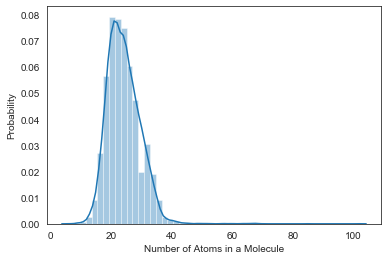

In [5]:
num_atoms=[]
large_molecule = []
large_molecule_class = []
heavy_molecule = []
heavy_molecule_class = []
for i in range(len(df_filter_2.index)):
    num_atoms.append( Chem.MolFromSmiles(df_filter_2.loc[i,'CANONICAL_SMILES']).GetNumAtoms())
    if Chem.MolFromSmiles(df_filter_2.loc[i,'CANONICAL_SMILES']).GetNumAtoms() > 60:
        large_molecule.append(df_filter_2.loc[i,'CANONICAL_SMILES'])
        large_molecule_class.append(df_filter_2.loc[i,'ACTIVITY_COMMENT'])
    if df_filter_2.loc[i,'MOLWEIGHT'] > 700:
        heavy_molecule.append(df_filter_2.loc[i,'CANONICAL_SMILES'])
        heavy_molecule_class.append(df_filter_2.loc[i,'ACTIVITY_COMMENT'])
sns.distplot(num_atoms)
plt.xlabel('Number of Atoms in a Molecule')
plt.ylabel('Probability')

The above figure shows the probability distribution of number of atoms in molecules. The distribution looks normal except for the right tail for molecules with large number of atoms. Let's take a look at those molecules.

Number of large molecules:
20


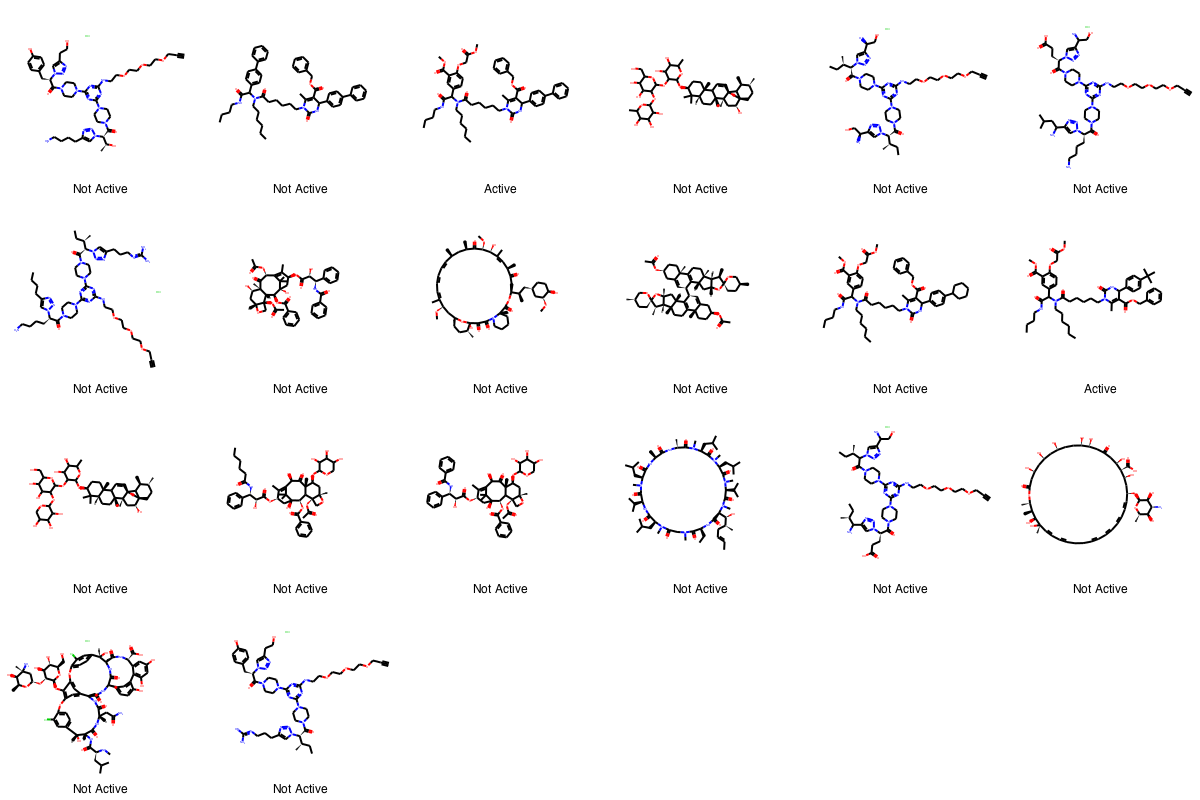

In [6]:
print('Number of large molecules:')
print(len(large_molecule))
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in large_molecule],molsPerRow=6,legends=large_molecule_class)

If we look carefully, there are 2 molecules among 20 large molecules that are active and can work as an inhibitor of NS1.

### Molecular Weight

Now, we plot the distribution of molecular weights.

Text(0.5, 0, 'MOLWEIGHT')

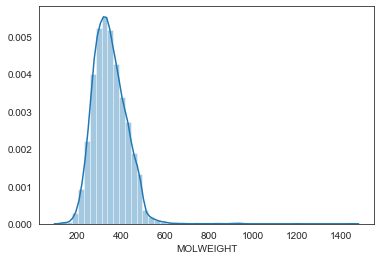

In [7]:
df_filter_2['MOLWEIGHT'].fillna(0, inplace=True)
sns.distplot(df_filter_2['MOLWEIGHT'])
plt.xlabel('MOLWEIGHT')

Number of large molecules:
29


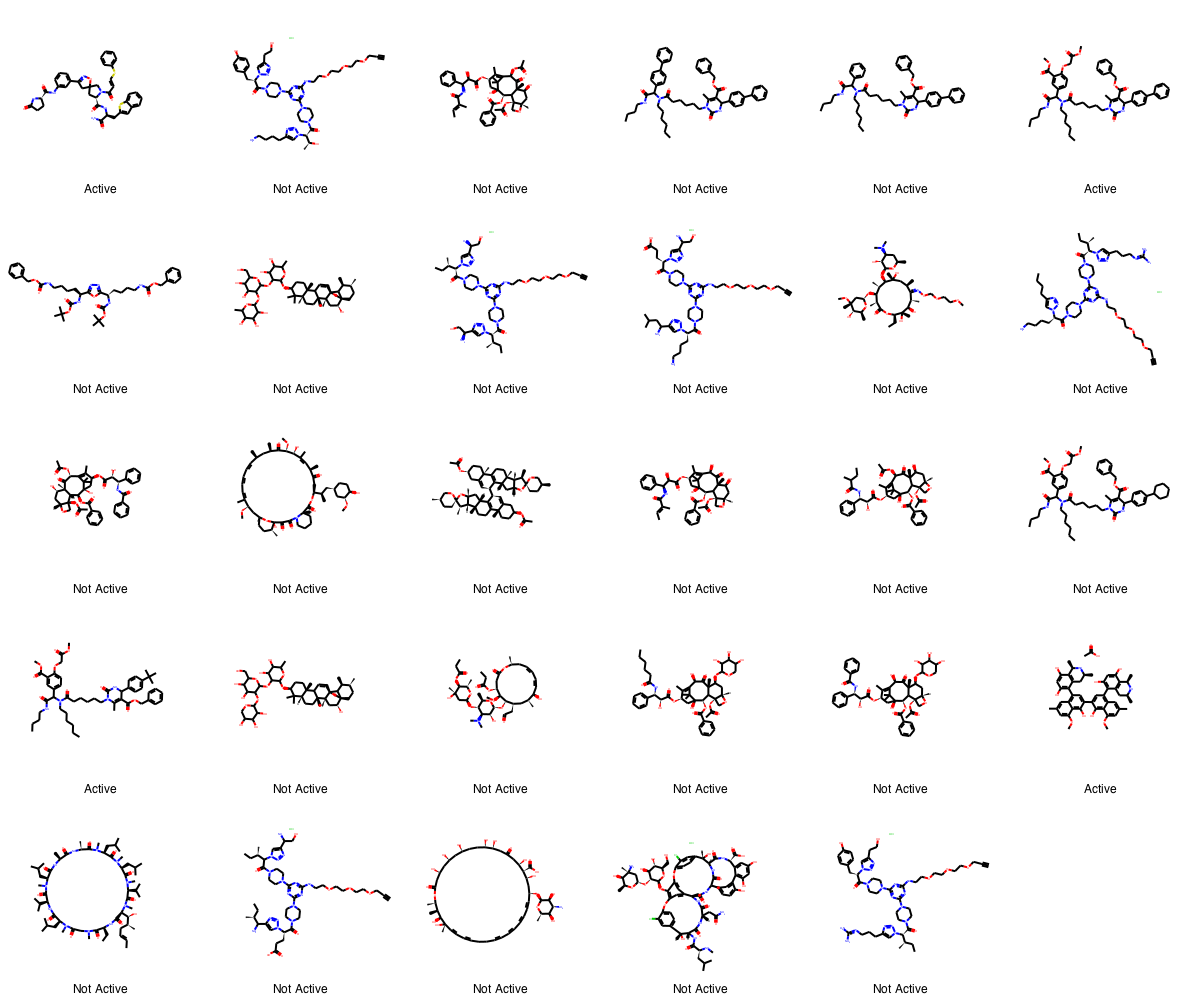

In [8]:
print('Number of large molecules:')
print(len(heavy_molecule))
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in heavy_molecule],molsPerRow=6,legends=heavy_molecule_class)

There are active molecules among heavy ones, too. So neither heavy nor large can be use to filter out some molecules to balance out the dataset. Even if all heavy and large molecules were inactive still the number is too small and could not balance the dataset. 

Number of large molecules:
20
Number of active large molecules:
2


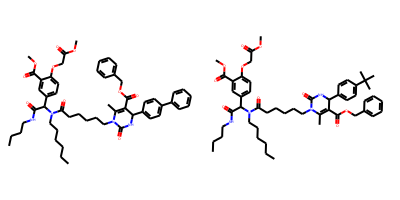

In [9]:
print('Number of large molecules:')
print(len(large_molecule))
active_large = [mol for index, mol in enumerate(large_molecule) if large_molecule_class[index] == 'Active']
print('Number of active large molecules:')
print(len(active_large))
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in active_large],molsPerRow=2)

Number of heavy molecules:
29
Number of active and heavy molecules:
4


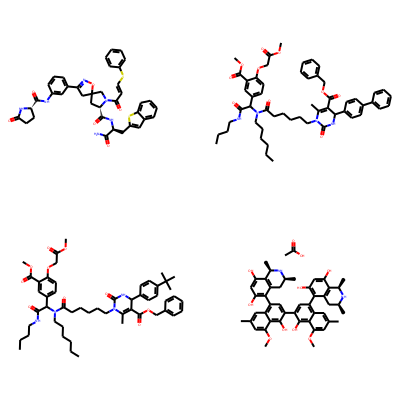

In [10]:
print('Number of heavy molecules:')
print(len(heavy_molecule))
active_heavy = [mol for index, mol in enumerate(heavy_molecule) if heavy_molecule_class[index] == 'Active']
print('Number of active and heavy molecules:')
print(len(active_heavy))
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in active_heavy],molsPerRow=2)

### Ring Size

Let's try an other way to filter out some inactive agents in order to balance the dataset. Molecules with large rings e.g. the group shown below are inactive:

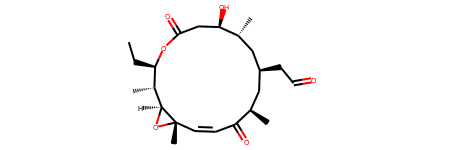

In [11]:
Chem.MolFromSmiles('CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H][C@@H](CC=O)C[C@@H](C)C(=O)C=C[C@]3(C)O[C@H]3[C@@H]1C')

Let's count them and see if removing them from dataset can be useful. We count rings with more than 14 atoms.

In [12]:
mols =  [Chem.MolFromSmiles(df_filter_2.loc[i,'CANONICAL_SMILES']) for i in range(len(df_filter_2.index))]
activity =  [df_filter_2.loc[i,'ACTIVITY_CLASS'] for i in range(len(df_filter_2.index))]

count_large_ring_not_active = 0
count_large_ring_active = 0
for i, mol in enumerate(mols):
    ri = mol.GetRingInfo()
    num_rings = ri.NumRings()
    index = 0
    atom_in_ring = 0
    for atom in mol.GetAtoms():
        if ri.NumAtomRings(index) == 1:
            atom_in_ring += 1
            max_size = 0
            for size in range(6, 50):
                if mol.GetAtomWithIdx(index).IsInRingSize(size) and size > max_size:
                    max_size = size
        index += 1
    if max_size > 14 and activity[i] == 0:
        count_large_ring_not_active += 1
    if max_size > 14 and activity[i] == 1:
        count_large_ring_active += 1
        

In [13]:
print("Number of inactive molecules with rings that contain more than 14 atoms:")
print(count_large_ring_not_active)
print("Number of active molecules with rings that contain more than 14 atoms:")
print(count_large_ring_active)

Number of inactive molecules with rings that contain more than 14 atoms:
7
Number of active molecules with rings that contain more than 14 atoms:
0


Neither of above strategies can balance the dataset because the number of inactive molecules which will be removed is very low. Therefore, I perform random removal of inactive samples:

First, randomly removing 10k not active agents:

In [14]:
import numpy as np
to_remove = np.random.choice(df_filter_2[df_filter_2['ACTIVITY_CLASS']==0].index,size=10000,replace=False)
df_filter_3 = df_filter_2.drop(to_remove)

In [15]:
df_filter_3 = df_filter_3.reset_index(drop=True)
df_filter_3.head()
print(df_filter_3.ACTIVITY_CLASS.value_counts())

0    12820
1     1072
Name: ACTIVITY_CLASS, dtype: int64


Now, there are ~13k not active and ~1k active molecules in the dataset.

Second, applying [SMOTE](https://www.jair.org/index.php/jair/article/download/10302/24590) to active examples and oversampling data: (for differences between SMOTE and SMOTENN check [here](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py))

Finally, training a random forest model and examining two thresholds on probability to determine which one to use for main training session of a collection of models.

In [17]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


# get molecules
mols = [Chem.MolFromSmiles(df_filter_3.loc[i,'CANONICAL_SMILES']) for i in range(len(df_filter_3.index))]

# generate fingeprints: Morgan fingerprint with radius 2 and size 512
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 512) for m in mols]

# convert the RDKit explicit vectors into numpy arrays
X = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    X.append(arr)

# get a random forest classifiert with 100 trees
rf = RandomForestClassifier(n_estimators=50, random_state=1123, bootstrap=False)

# get labels
y = [df_filter_3.loc[i,'ACTIVITY_CLASS'] for i in range(len(df_filter_3.index))]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# train the random forest
rf.fit(X_train_res, y_train_res)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1123,
                       verbose=0, warm_start=False)


########### threshold: 0.5 ##########
Average precision-recall score: 0.11
[[2574    5]
 [ 187   13]]


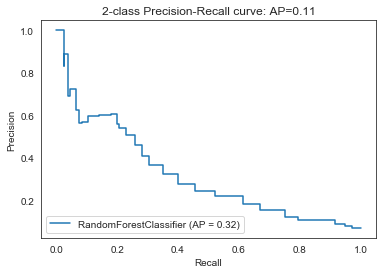

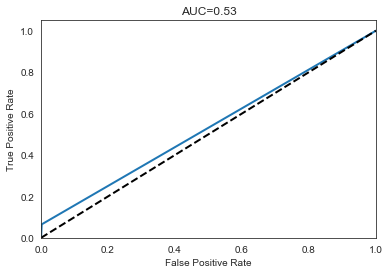

Accuracy: 0.9309103994242534
F1: 0.11926605504587157
Recall: 0.065
Precision: 0.7222222222222222
kappa: 0.1086729188035187

########### threshold: 0.1 ##########
Average precision-recall score: 0.14
[[1777  802]
 [  50  150]]


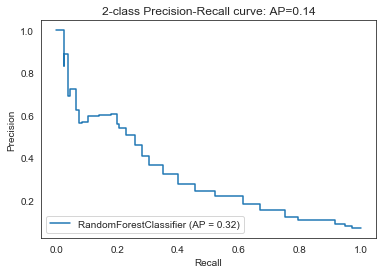

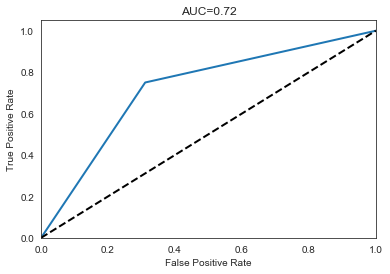

Accuracy: 0.6934148974451242
F1: 0.2604166666666667
Recall: 0.75
Precision: 0.15756302521008403
kappa: 0.1605682179161373


In [19]:
for threshold in [0.5, 0.1]:
    print()
    print('########### threshold:', threshold, '##########')
    predicted_proba = rf.predict_proba(X_test)
    y_pred = (predicted_proba [:,1] >= threshold).astype('int')

#     y_pred = rf.predict(X_test)

    average_precision = metrics.average_precision_score(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    disp = metrics.plot_precision_recall_curve(rf, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    print(metrics.confusion_matrix(y_test,y_pred))
    
    fpr,tpr,_ = metrics.roc_curve(y_test,y_pred);
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, lw=lw)
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("AUC={0:0.2f}".format(metrics.auc(fpr, tpr)))
    plt.show()
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("kappa:", cohen_kappa_score(y_test, y_pred))

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline


names = [
    "Nearest Neighbors", 
    "Linear SVM", 
#          "RBF SVM", 
#          "Gaussian Process",
#          "Decision Tree", 
         "Random Forest", 
    "Neural Net", 
#     "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.001, probability=True),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0), max_iter_predict=10, warm_start=True),
#     DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(n_estimators=40, random_state=1123, bootstrap=False, max_depth=10),
    MLPClassifier(alpha=1, max_iter=1000, hidden_layer_sizes=(10,)),
#     AdaBoostClassifier(),
    GaussianNB()]


parameters = {}
# iterate over classifiers
for name, clf in zip(names, classifiers):
    print('########## '+ name + ' ##########')
    gs_clf = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, refit=True, return_train_score=True)
    gs_clf = gs_clf.fit(X_train_res, y_train_res)
#     try:
#         threshold = 0.2
#         predicted_proba = gs_clf.predict_proba(X_test)
#         y_pred = (predicted_proba [:,1] >= threshold).astype('int')
#     except:
    y_pred = gs_clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('mean_test_score = ', gs_clf.cv_results_['mean_test_score'][0])
    print('mean_train_score = ', gs_clf.cv_results_['mean_train_score'][0])
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y_test,y_pred))
#     average_precision = metrics.average_precision_score(y_test, y_pred)
#     disp = metrics.plot_precision_recall_curve(gs_clf, X_test, y_test)
#     disp.ax_.set_title('Precision-Recall curve: '
#                    'AP={} {}'.format(average_precision, name))
    print()


# Clustering

I apply clustering on molecules based on **Jaccard / Tanimoto** similarity measure which has been shown [here](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3) to work well for fingerprint based featurization of molecules. Here, I use Morgan Fingerprint. For a review on different fingerprints and the concept you can see these [slides](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf).

In [22]:
def ClusterFps(fps,cutoff=0.3):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem
import gzip
fps = [AllChem.GetMorganFingerprintAsBitVect(m,2,256) for m in mols]
clusters=ClusterFps(fps,cutoff=0.4)

In [24]:
from collections import defaultdict
count = defaultdict(int)
for c in clusters:
    count[len(c)] += 1
print(count)        

defaultdict(<class 'int'>, {17: 1, 15: 1, 14: 4, 13: 1, 12: 5, 9: 14, 11: 2, 8: 27, 6: 67, 10: 13, 7: 42, 3: 500, 4: 227, 5: 107, 2: 1268, 1: 7062})


There are 1 cluster of 17 molecules with similar structures. There are 500 clusters each of size 3. And 7062 individual molecules which do not belong to any cluster.

In [28]:
counter = 0
for c in clusters:
    active_c = True
    for mol_index in c:
        if y[mol_index] == 0:
            active_c = False
            break
    if active_c == True:
        print(c)
        counter += 1
    
    if counter == 20:
        break
            

(13324, 3319, 4449, 8582, 12915, 12981)
(12729, 117, 985, 1301, 5407)
(12348, 5313, 5849, 6583)
(8711, 3505, 8185, 12856)
(8012, 6156)
(5365,)
(1500, 1539, 1703, 2442)
(1296, 2739, 2750)
(13880, 2598, 3201)
(13351, 3802, 6921)
(13250, 6755, 11907)
(12034, 7319, 13082)
(10391, 4707, 9776)
(10143, 1230, 9636)
(9860, 10286)
(9497, 190, 1211)
(8256, 5933, 7428)
(8069, 3143, 3395)
(7910,)
(6938,)


Take a look at the molecular structures in each cluster:

In [42]:
c1 = (13324, 3319, 4449, 8582, 12915, 12981)
c2 = (12729, 117, 985, 1301, 5407)
c3 = (6938,)
for i in c1:
    print(y[i])

1
1
1
1
1
1


## Cluster of size 6

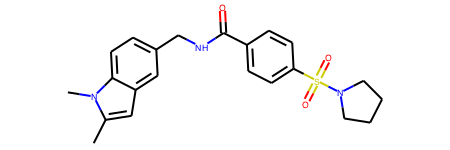

In [43]:
mols[c1[0]]

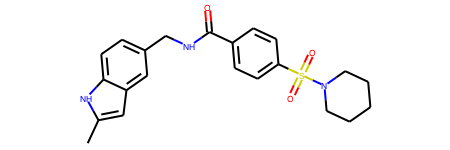

In [44]:
mols[c1[1]]

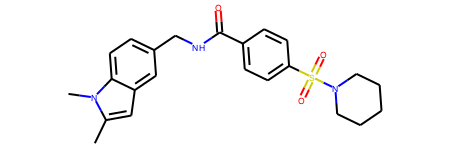

In [45]:
mols[c1[2]]

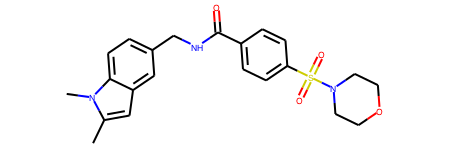

In [46]:
mols[c1[3]]

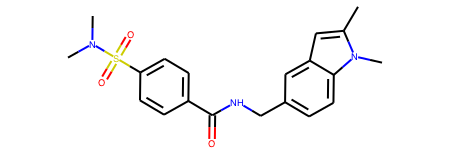

In [47]:
mols[c1[4]]

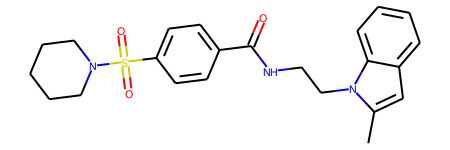

In [48]:
mols[c1[5]]

## Cluster of size 5

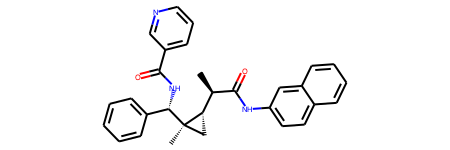

In [49]:
mols[c2[0]]

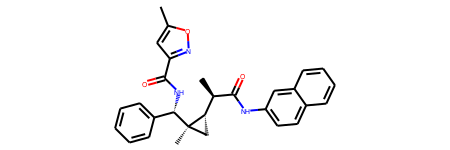

In [50]:
mols[c2[4]]

## Individual molecule

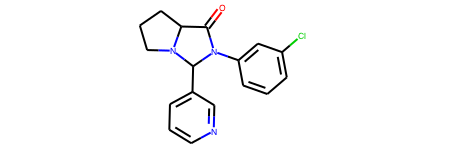

In [51]:
mols[c3[0]]